Import Libraries 

In [4]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

Load Dataset

In [5]:
df = pd.read_csv("./DisneylandReviews.csv", encoding='latin-1')
pd.set_option('display.max_colwidth', None) 


In [6]:
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small World is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well.,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!",Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,"Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.",Disneyland_HongKong
3,670607911,4,2019-4,Australia,"HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midweek, it is not too crowded and certainly no where near as bus as LA Disneyland. We did notice on this visit that prices for food, drinks etc have really gone through the roof so be prepared to pay top dollar for snacks (and avoid the souvenir shops if you can) Regardless, kids will love it.",Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thought it was brilliant. i visited all the hotels and stayed in the newport bay and also the kyriad hotels. the newport is a really nice hotel within walking distance of the parks. very big hotel. the kyriad is further away but still a really nice hotel..i saw all rooms at all hotels and they are all pretty much the same. thought the parks were brill and as it was july didn't really have to queue that much i thought. the food was the most expensive thing there. i did the character breakfast which is a must especially if you have young kids and also did buffalo bills which is a really good night. stayed up til late in the nightclub which i didn't think was expe

Data Exploring

In [7]:
df.shape

(42656, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [9]:
df.isnull().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(12)

Data Cleaning

In [11]:
# Drop ducplicates
df.drop_duplicates(subset='Review_Text', inplace=True, keep='first')

In [12]:
len(df[df['Year_Month']=='missing'])

2610

In [13]:
# Function to extract month and year
def extract_month_year(text):
    month_pattern = r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b'
    year_pattern = r'\b(20\d{2}|195[6-9]|196\d|197\d|198\d|199\d|200\d)\b'  # Matches years 1956-2099
    
    month_match = re.search(month_pattern, text, re.IGNORECASE)
    year_match = re.search(year_pattern, text)
    
    month = month_match.group(0) if month_match else None
    year = year_match.group(0) if year_match else None
    
    return month, year

# Function to update Year_Month column
def update_year_month(row):
    if row['Year_Month'] == 'missing':  # Only update if Year_Month is marked as 'missing'
        month, year = extract_month_year(row['Review_Text'])
        if month and year:  # Only update if both month and year are found
            month_mapping = {
                'january': 1, 'february': 2, 'march': 3, 'april': 4,
                'may': 5, 'june': 6, 'july': 7, 'august': 8,
                'september': 9, 'october': 10, 'november': 11, 'december': 12,
                'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
            }
            month_num = month_mapping.get(month.lower())
            return f"{year}-{month_num}"
        else:
            return None  # Return None if either month or year is missing
    return row['Year_Month']  # If it's not 'missing', return the existing value

# Update the Year_Month column
df['Year_Month'] = df.apply(update_year_month, axis=1)

# Drop rows where Year_Month is None
df = df.dropna(subset=['Year_Month'])


In [14]:
# Checking Missing Values and Unique Values of columns
print ("Rows: " ,df.shape[0])
print ("Columns: " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows:  40167
Columns:  6

Features : 
 ['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text', 'Branch']

Missing values :   0

Unique values :  
 Review_ID            40159
Rating                   5
Year_Month             188
Reviewer_Location      162
Review_Text          40167
Branch                   3
dtype: int64


In [15]:
# Splitting Year_Month column
year_month = df['Year_Month'].str.split('-',expand=True, n=1)
df['Year'] = year_month[0]
df['Month'] = year_month[1]
df.drop('Year_Month', axis=1, inplace=True)

/var/folders/51/x0s_18xd3zbbzj6wr9lx_q580000gn/T/ipykernel_1105/694475404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = year_month[0]
/var/folders/51/x0s_18xd3zbbzj6wr9lx_q580000gn/T/ipykernel_1105/694475404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = year_month[1]
/var/folders/51/x0s_18xd3zbbzj6wr9lx_q580000gn/T/ipykernel_1105/694475404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

In [16]:
df.dtypes

Review_ID             int64
Rating                int64
Reviewer_Location    object
Review_Text          object
Branch               object
Year                 object
Month                object
dtype: object

In [17]:
# Converting Year and Month into integer columns
df['Year'] = df['Year'].astype('int64')
df['Month'] = df['Month'].astype('int64')

/var/folders/51/x0s_18xd3zbbzj6wr9lx_q580000gn/T/ipykernel_1105/2489366235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype('int64')
/var/folders/51/x0s_18xd3zbbzj6wr9lx_q580000gn/T/ipykernel_1105/2489366235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Month'].astype('int64')


Data Exploration (EDA)

In [18]:
df['Branch'].value_counts()

Branch
Disneyland_California    18259
Disneyland_Paris         12745
Disneyland_HongKong       9163
Name: count, dtype: int64

In [19]:
# Dividing Branch into three different datasets for analysis
ca_df = df[df['Branch']== "Disneyland_California"]
pa_df = df[df['Branch']== "Disneyland_Paris"]
hk_df = df[df['Branch']== "Disneyland_HongKong"]

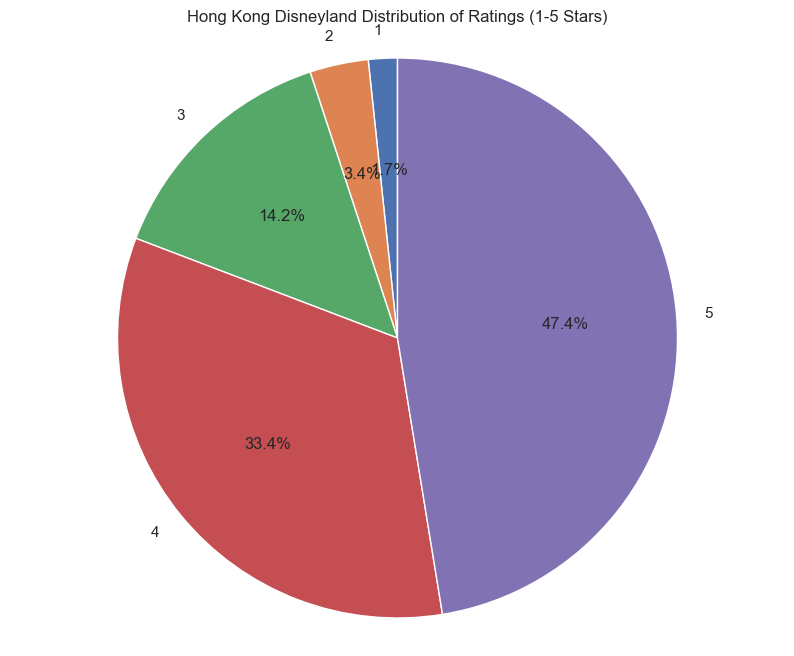

In [20]:
# Pie Chart of Rating Distribution for Hong Kong Disneyland
rating_counts = hk_df['Rating'].value_counts().sort_index()
sns.set_theme(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Hong Kong Disneyland Distribution of Ratings (1-5 Stars)')
plt.axis('equal')  

# Show the plot
plt.show()

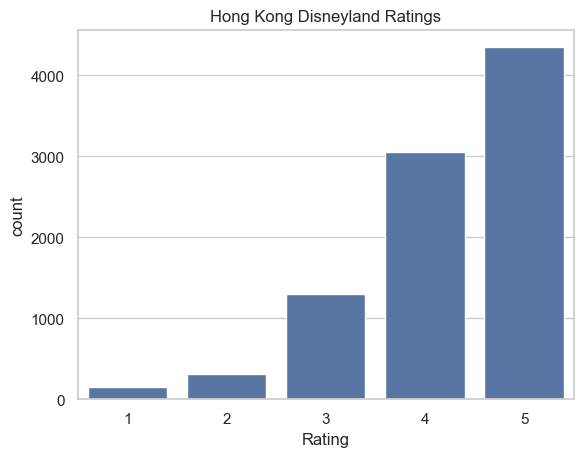

In [21]:
# Bar Chart for Distribution Rating of Hong Kong Disneyland
sns.countplot(x='Rating', data=hk_df)
plt.title('Hong Kong Disneyland Ratings')
plt.show()

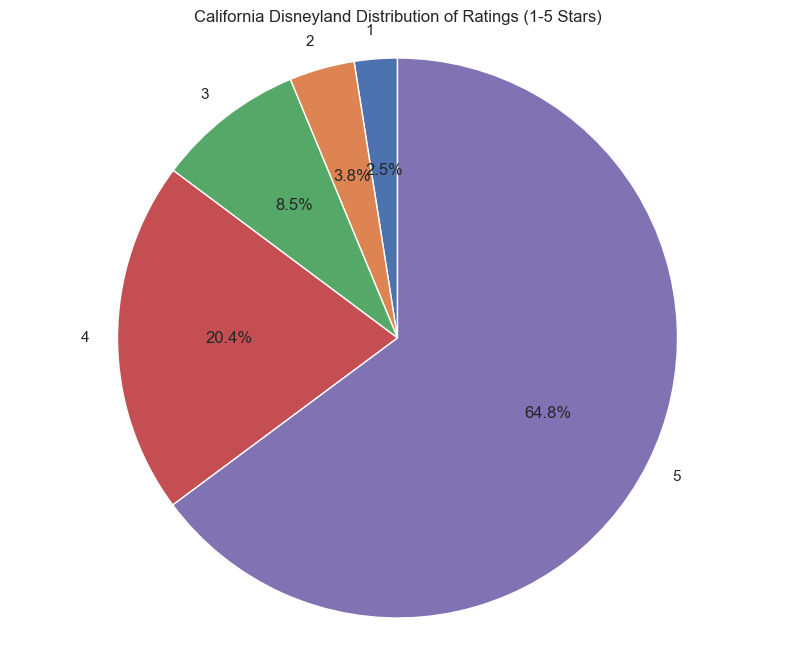

In [22]:
# Pie Chart of Rating Distribution for California Disneyland
rating_counts = ca_df['Rating'].value_counts().sort_index()
sns.set_theme(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('California Disneyland Distribution of Ratings (1-5 Stars)')
plt.axis('equal') 

# Show the plot
plt.show()

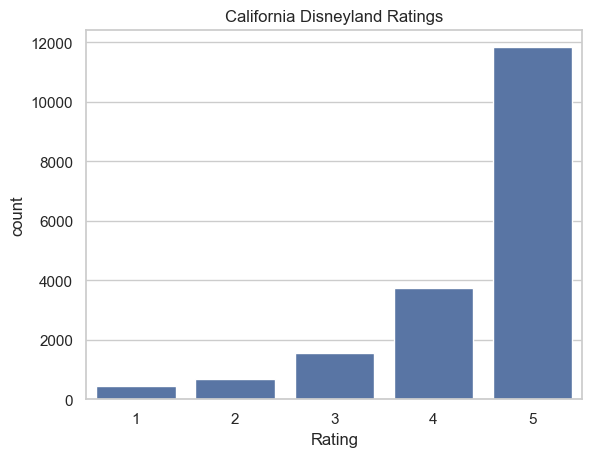

In [23]:
# Bar Chart for Distribution Rating of California Disneyland
sns.countplot(x='Rating', data=ca_df)
plt.title('California Disneyland Ratings')
plt.show()

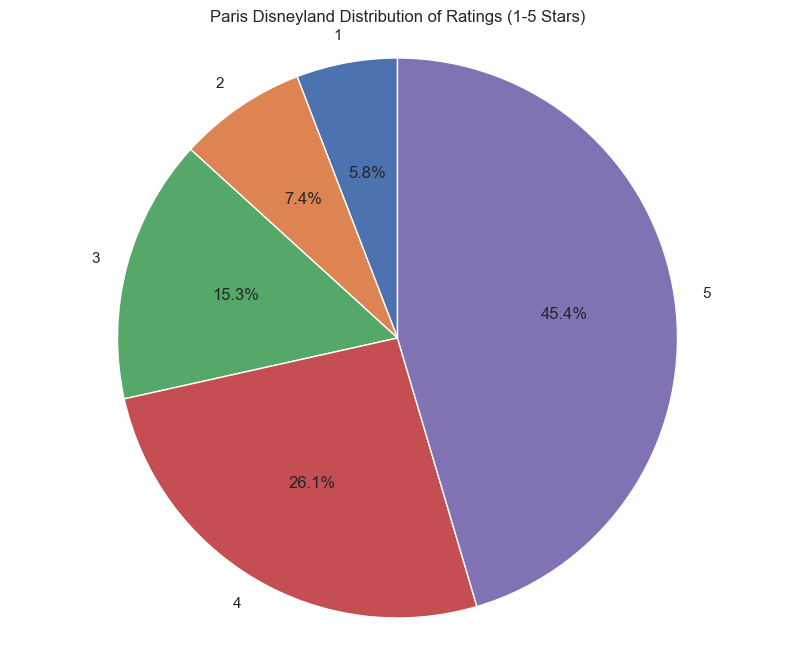

In [24]:
# Pie Chart of Rating Distribution for Paris Disneyland
rating_counts = pa_df['Rating'].value_counts().sort_index()
sns.set_theme(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Paris Disneyland Distribution of Ratings (1-5 Stars)')
plt.axis('equal')  

# Show the plot
plt.show()

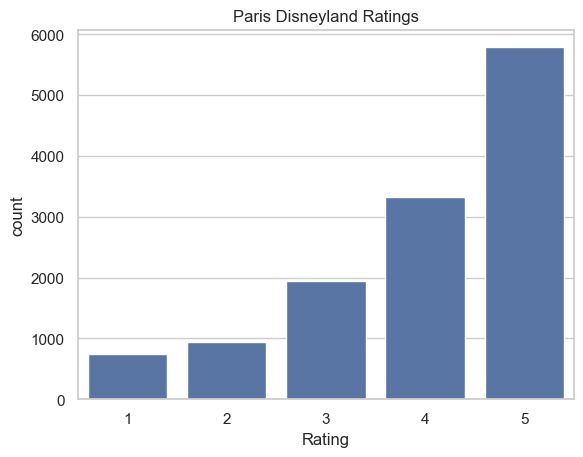

In [25]:
# Bar Chart for Distribution Rating of Paris Disneyland
sns.countplot(x='Rating', data=pa_df)
plt.title('Paris Disneyland Ratings')
plt.show()

In [26]:
# Generating Sentiment Analysis Score based on Reviews

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis
df['Sentiment'] = df['Review_Text'].apply(get_sentiment)


[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
/var/folders/51/x0s_18xd3zbbzj6wr9lx_q580000gn/T/ipykernel_1105/2472710352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Review_Text'].apply(get_sentiment)


In [27]:
# Getting the most common words associated with low and high sentiment scores

# Define thresholds
low_threshold = 0.5
high_threshold = 0.5

# Separate reviews based on sentiment
low_sentiment_reviews = df[df['Sentiment'] < low_threshold]['Review_Text']
high_sentiment_reviews = df[df['Sentiment'] > high_threshold]['Review_Text']

# Function to tokenize and clean text
def clean_and_tokenize(texts):
    stop_words = set(stopwords.words('english'))
    stop_words.update(["disney", "park", "disneyland", "get", "go", "one", "would", "place", "went", "even", "us", "day", "really", "see", "also", "like", "much", "visit", "could", "back", "parks", "great", "good", "many"])
    words = []
    for text in texts:
        tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
        words += [word for word in tokens if word.isalpha() and word not in stop_words]  # Keep only words
    return words

# Get words for both sentiment groups
low_words = clean_and_tokenize(low_sentiment_reviews)
high_words = clean_and_tokenize(high_sentiment_reviews)

# Count word frequencies
low_word_counts = Counter(low_words)
high_word_counts = Counter(high_words)

# Get most common words
low_common = low_word_counts.most_common(10)
high_common = high_word_counts.most_common(10)

# Display results
print("Most common words in low sentiment reviews:")
for word, count in low_common:
    print(f"{word}: {count}")

print("\nMost common words in high sentiment reviews:")
for word, count in high_common:
    print(f"{word}: {count}")

Most common words in low sentiment reviews:
rides: 5217
time: 3631
ride: 2628
people: 2321
food: 2231
kids: 1773
long: 1719
wait: 1574
staff: 1544
closed: 1500

Most common words in high sentiment reviews:
rides: 27121
time: 23693
ride: 13817
kids: 11254
food: 10976
fun: 8665
fast: 8073
people: 7896
pass: 7894
long: 7886


In [28]:
# Creating a dataframe for common words associated with high and low sentiment scores

high_df = pd.DataFrame(high_common, columns=['Word', 'Count'])
high_df['Sentiment'] = 'High'

low_df = pd.DataFrame(low_common, columns=['Word', 'Count'])
low_df['Sentiment'] = 'Low'

# Combine the DataFrames
sentiment_df = pd.concat([high_df, low_df], ignore_index=True)

# Display the resulting DataFrame
print(sentiment_df)

      Word  Count Sentiment
0    rides  27121      High
1     time  23693      High
2     ride  13817      High
3     kids  11254      High
4     food  10976      High
5      fun   8665      High
6     fast   8073      High
7   people   7896      High
8     pass   7894      High
9     long   7886      High
10   rides   5217       Low
11    time   3631       Low
12    ride   2628       Low
13  people   2321       Low
14    food   2231       Low
15    kids   1773       Low
16    long   1719       Low
17    wait   1574       Low
18   staff   1544       Low
19  closed   1500       Low


Exporting dataset

In [29]:
df.to_csv('./updated_disneylandreviews.csv', index=False)
sentiment_df.to_csv('./sentiment_disneylandreviews.csv', index=False)